# Project: Machine Learning Regression Analysis on World Happiness

## Importing necessary libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error

SEED = 42
np.random.seed(SEED)

In [29]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Add this line to ignore all ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Reading datasets

In [30]:
train_df = pd.read_csv('/content/happiness_data_train.csv')
test_df = pd.read_csv('/content/happiness_data_test.csv')

# Part A

In [31]:
print("\n--- PART A: DATA SUMMARY ---")
print(f"Training data shape: {train_df.shape}")
print("\nData types and null values:")
train_df.info()


--- PART A: DATA SUMMARY ---
Training data shape: (1559, 9)

Data types and null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1559 entries, 0 to 1558
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Life Ladder                       1559 non-null   float64
 1   Log GDP per capita                1533 non-null   float64
 2   Social support                    1549 non-null   float64
 3   Healthy life expectancy at birth  1522 non-null   float64
 4   Freedom to make life choices      1537 non-null   float64
 5   Generosity                        1488 non-null   float64
 6   Perceptions of corruption         1473 non-null   float64
 7   Positive affect                   1542 non-null   float64
 8   Negative affect                   1545 non-null   float64
dtypes: float64(9)
memory usage: 109.7 KB


### Data Summary



- **Dataset size:**

  - **Total entries:** 1,559 rows

  - **Total features (including target):** 9 columns



---



### Attributes Overview



| # | Feature Name | Non-null Count | Data Type | Description / Notes |

|---|---------------|----------------|------------|----------------------|

| 0 | **Life Ladder** | 1,559 | float64 | Target variable (measure of happiness) |

| 1 | **Log GDP per capita** | 1,533 | float64 | Economic indicator — continuous |

| 2 | **Social support** | 1,549 | float64 | Perceived social support — continuous |

| 3 | **Healthy life expectancy at birth** | 1,522 | float64 | Average lifespan — continuous |

| 4 | **Freedom to make life choices** | 1,537 | float64 | Perceived freedom — continuous |

| 5 | **Generosity** | 1,488 | float64 | Measure of generosity — continuous |

| 6 | **Perceptions of corruption** | 1,473 | float64 | Trust/corruption perception — continuous |

| 7 | **Positive affect** | 1,542 | float64 | Positive emotions frequency — continuous |

| 8 | **Negative affect** | 1,545 | float64 | Negative emotions frequency — continuous |



---



### Data Type Breakdown



- **Continuous-valued attributes:**

  All columns are numeric (`float64`) — meaning **all features are continuous**.

  **No categorical or ordinal attributes are present in this dataset.**



- **Target variable:**

  `Life Ladder` (continuous numeric variable, suitable for regression tasks).



---



### Missing Data



Some features contain missing values:



| Feature | Missing Values |

|----------|----------------|

| Log GDP per capita | 26 |

| Social support | 10 |

| Healthy life expectancy at birth | 37 |

| Freedom to make life choices | 22 |

| Generosity | 71 |

| Perceptions of corruption | 86 |

| Positive affect | 17 |

| Negative affect | 14 |



---



### Summary Statement



> The dataset contains 1,559 observations and 9 continuous attributes, with moderate amounts of missing data in several features. Since all attributes are numeric and continuous, preprocessing steps such as imputation, normalization, and outlier removal are appropriate before model training.



# Part B

In [32]:
print("\n--- PART B: STATISTICAL ANALYSIS ---")
print("\nDescriptive Statistics:")
print(train_df.describe())


--- PART B: STATISTICAL ANALYSIS ---

Descriptive Statistics:
       Life Ladder  Log GDP per capita  Social support  \
count  1559.000000         1533.000000     1549.000000   
mean      5.469321            9.362995        0.812689   
std       1.113280            1.160240        0.118762   
min       2.375000            6.635000        0.290000   
25%       4.649500            8.460000        0.753000   
50%       5.374000            9.456000        0.835000   
75%       6.272500           10.332000        0.905000   
max       8.019000           11.648000        0.987000   

       Healthy life expectancy at birth  Freedom to make life choices  \
count                       1522.000000                   1537.000000   
mean                          63.331680                      0.741882   
std                            7.478307                      0.142326   
min                           32.300000                      0.260000   
25%                           58.340000          

In [33]:
print(f"\nMissing values before imputation:\n{train_df.isnull().sum()}")


Missing values before imputation:
Life Ladder                          0
Log GDP per capita                  26
Social support                      10
Healthy life expectancy at birth    37
Freedom to make life choices        22
Generosity                          71
Perceptions of corruption           86
Positive affect                     17
Negative affect                     14
dtype: int64



Generating attribute histograms...


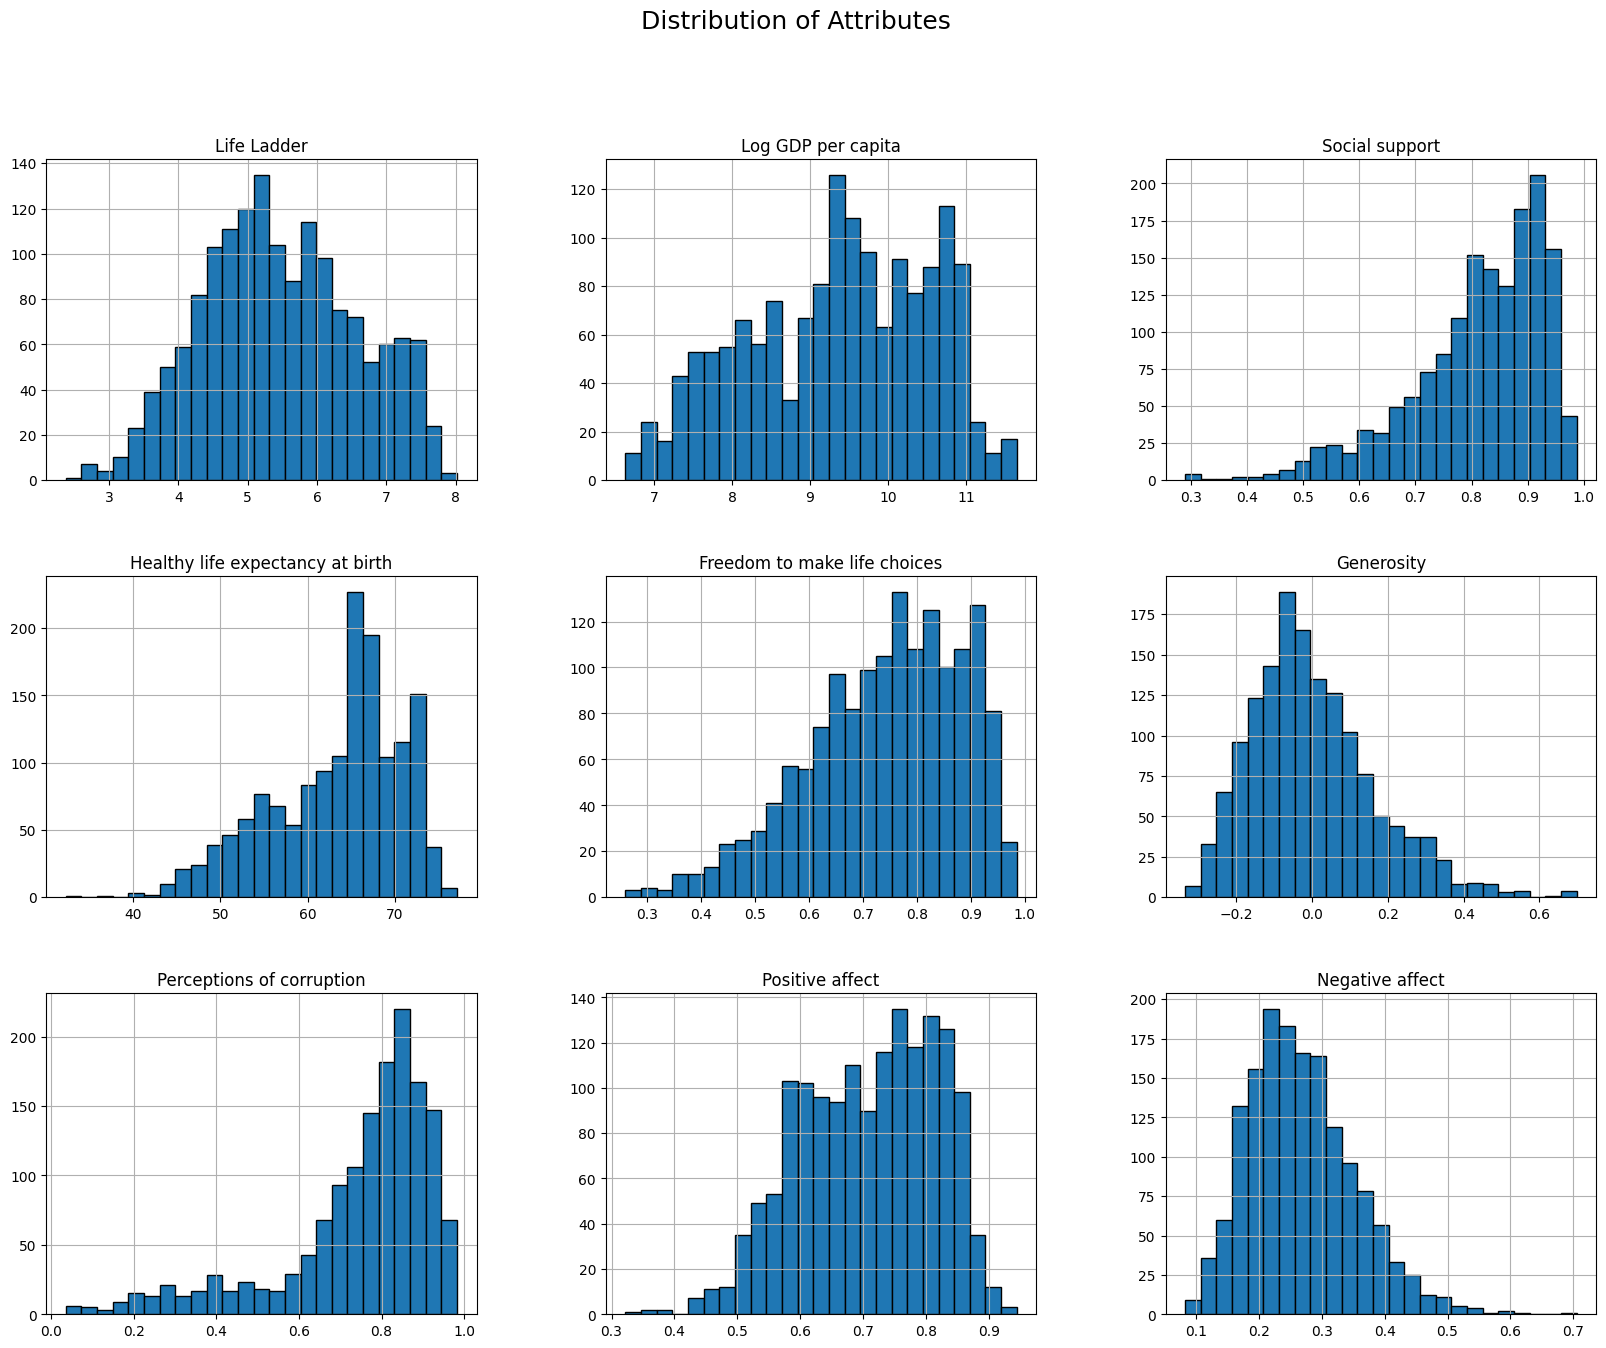

In [34]:
# Histograms for distributions
print("\nGenerating attribute histograms...")
train_df.hist(bins=25, figsize=(20, 15), edgecolor='black')
plt.suptitle("Distribution of Attributes", fontsize=18)
plt.show()

Statistical Summary: The descriptive statistics immediately highlight a significant issue - varying scales across features.

**Analysis of Distributions**

**Near-Normal / Symmetric:** Life Ladder and Positive affect show a roughly symmetric, bell-shaped distribution.

**Left-Skewed (Concentrated at High Values):** Social support, Healthy life expectancy, Perceptions of corruption and Freedom to make life choices are all slightly left-skewed.

**Right-Skewed (Concentrated at Low Values):** Generosity and Negative affect are heavily right-skewed, with most data points clustered at the low end of the scale.

**Bimodal (Two Peaks):** The most problematic and insightful features are Log GDP per capita. It clearly show two distinct peaks. This is a strong indicator of two underlying subgroups within the data, likely corresponding to developed vs. developing economies, which a simple linear model will struggle to capture effectively.

**Attributes Requiring Special Treatment**

Based on the statistical and visual analysis, several attributes require special preprocessing to ensure the model performs optimally and reliably.

1. **Missing Values (Critical)**

The output of train_df.isnull().sum() shows that several columns have missing data. Leaving these as NaNs would cause the model training to fail.

**Action:** Imputation

A robust strategy is to fill missing values with the median of their respective columns. The median is preferred over the mean as it is less sensitive to outliers, which is crucial for skewed distributions.



---



2. **Varying Feature Scales (Critical)**

The features have vastly different ranges and standard deviations (e.g., Healthy life expectancy vs. Generosity). This can cause features with larger scales to unfairly dominate the model's learning process, especially for distance-based or gradient-based algorithms like SGD.

**Action:** Feature Scaling

Applying Standardization (StandardScaler) is the best practice. This will transform all features to have a mean of 0 and a standard deviation of 1, ensuring they are on a common scale and contribute equally to the model's training.



---



3. **Potential Outliers (Important)**

The histograms and the .describe() output suggest the presence of outliers. These extreme values can disproportionately influence the model's parameters and skew the overall results, leading to a less accurate model.

**Action:** Outlier Capping

A standard method is to use the Interquartile Range (IQR) to identify and "cap" outliers. This involves replacing extreme values with the highest or lowest value within an acceptable range (typically 1.5 * IQR from the first or third quartile), which makes the model more robust without completely discarding the data points.

# Part C


--- PART C: RELATIONSHIP ANALYSIS ---

Computing Pearson Correlation Coefficient and generating heatmap...


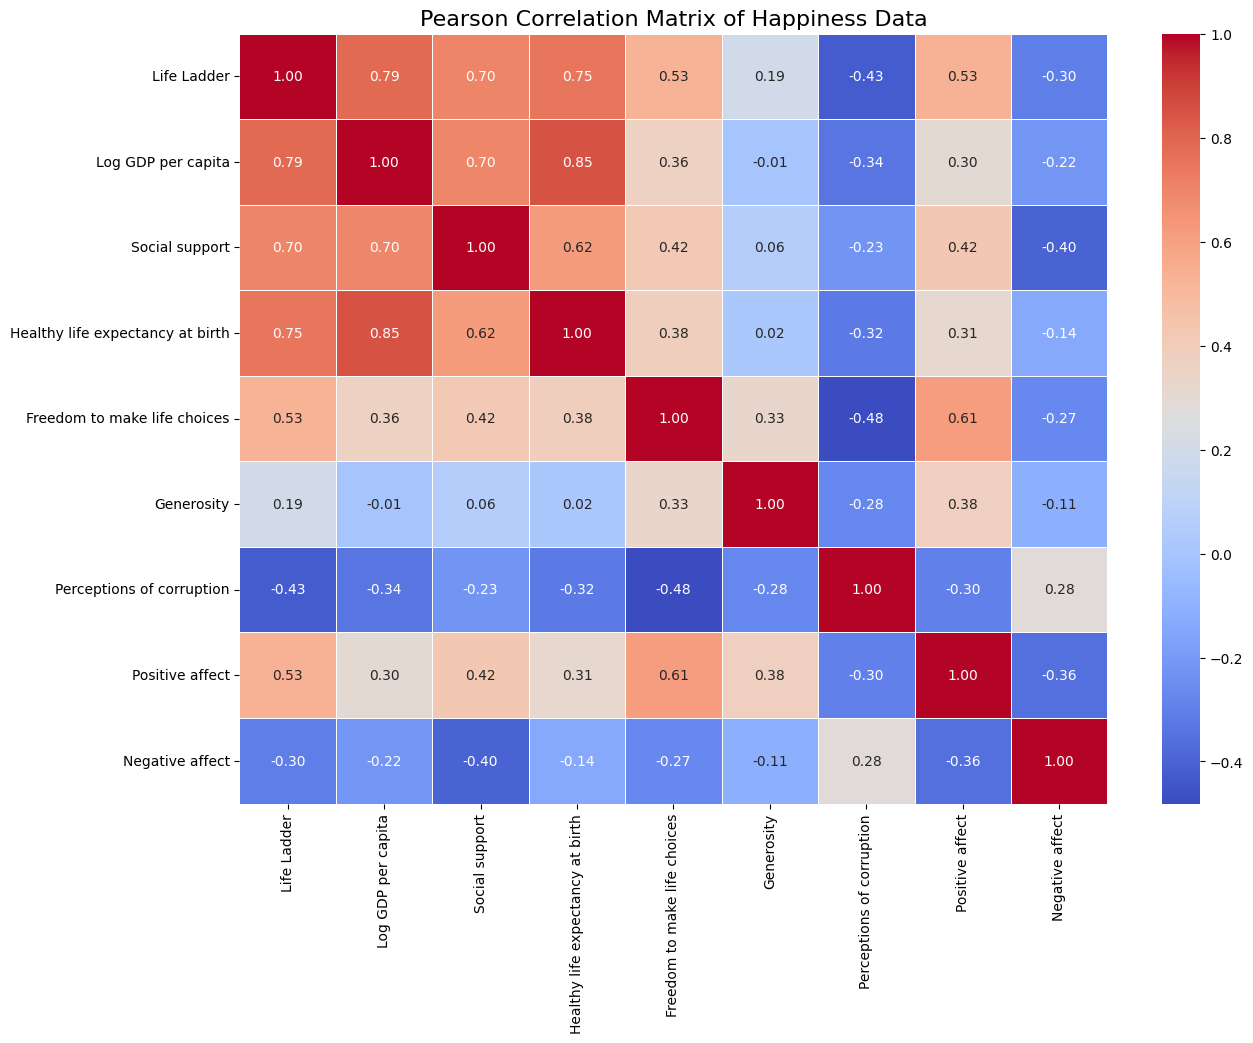


Generating scatter plots...


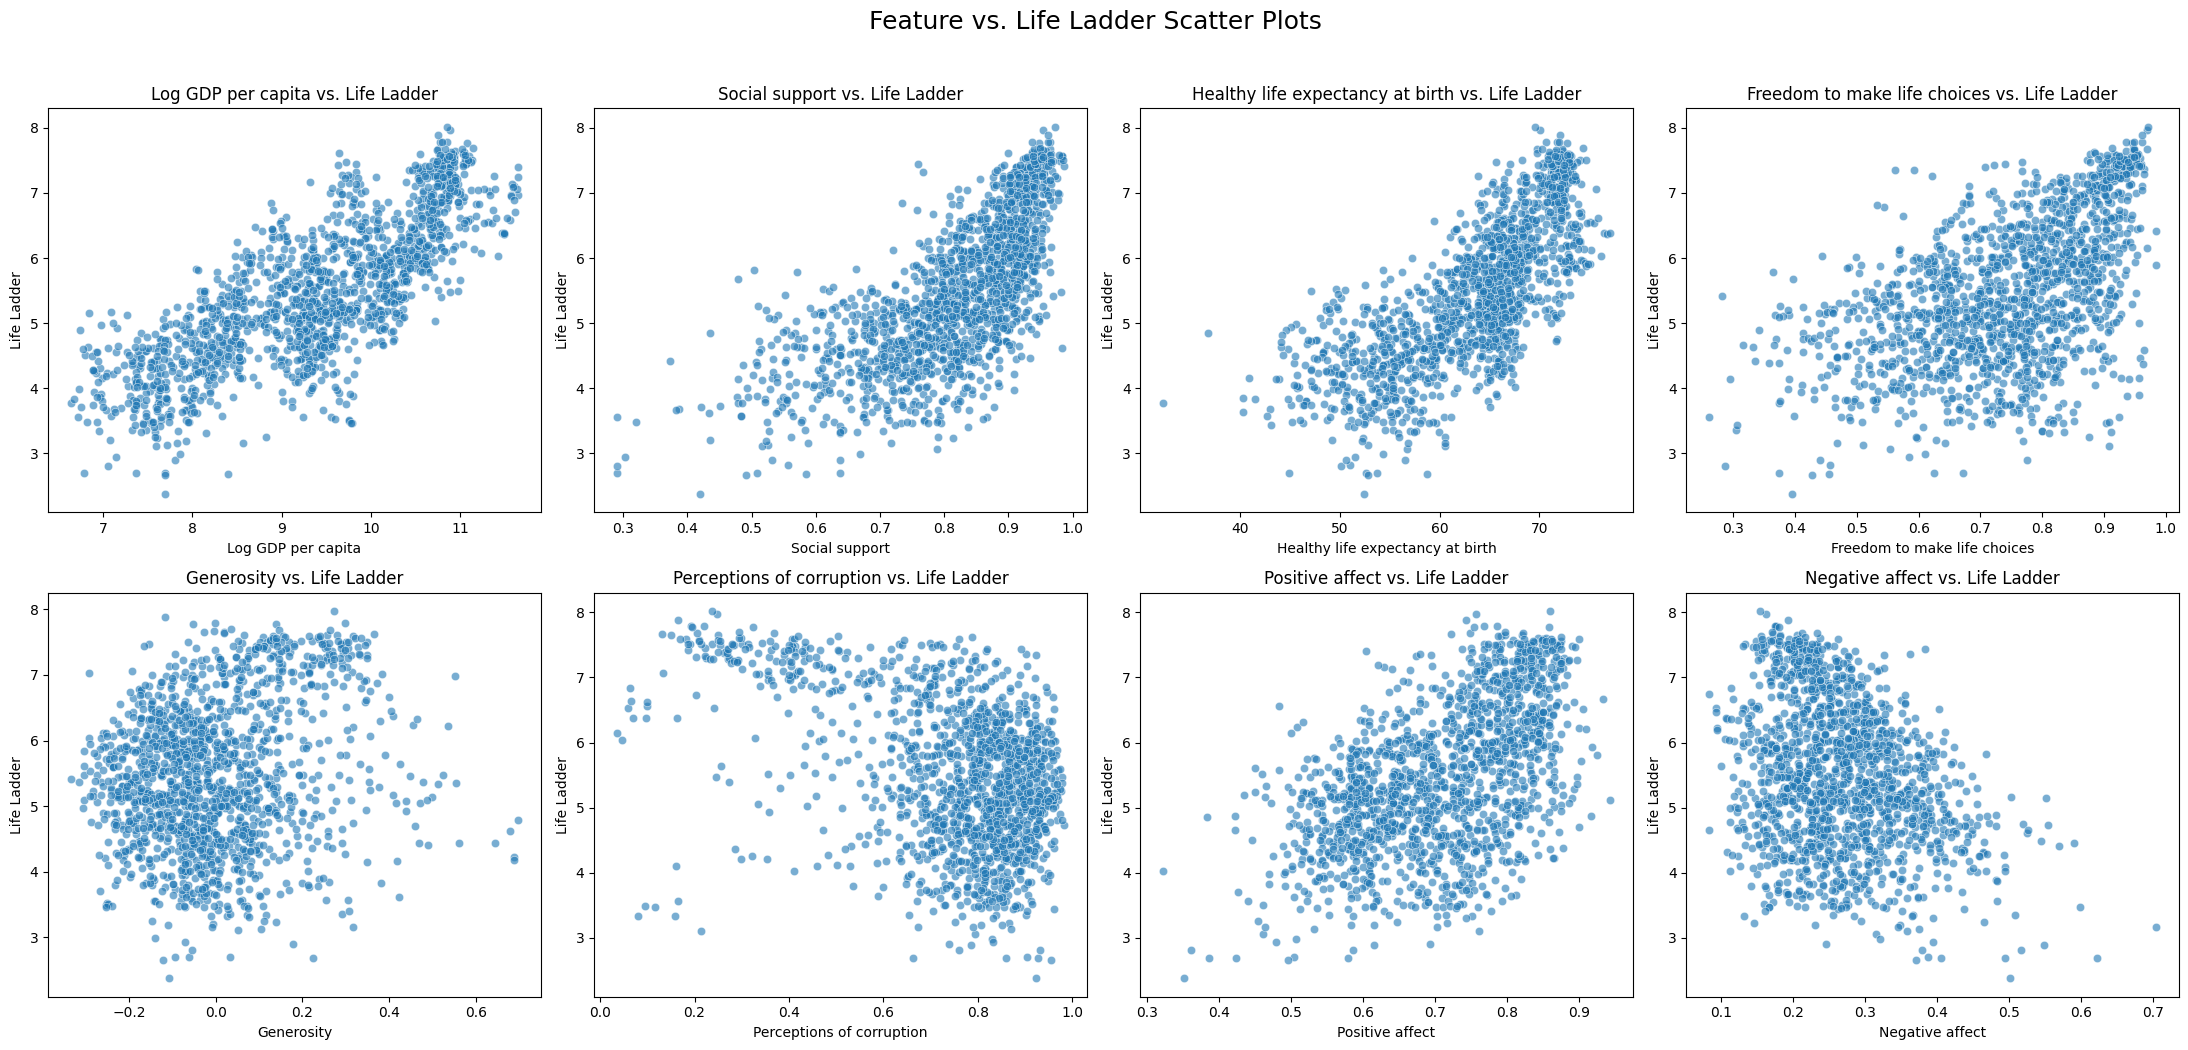

In [35]:
print("\n--- PART C: RELATIONSHIP ANALYSIS ---")
# Pearson Correlation Coefficient Heatmap
print("\nComputing Pearson Correlation Coefficient and generating heatmap...")
corr_matrix = train_df.corr(method='pearson')
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation Matrix of Happiness Data', fontsize=16)
plt.show()

# Scatter Plots of Features vs. Life Ladder
print("\nGenerating scatter plots...")
features_for_plot = [col for col in train_df.columns if col != 'Life Ladder']
target = 'Life Ladder'
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 11))
fig.suptitle('Feature vs. Life Ladder Scatter Plots', fontsize=18)
axes = axes.flatten()
for i, feature in enumerate(features_for_plot):
    sns.scatterplot(data=train_df, x=feature, y=target, ax=axes[i], alpha=0.6)
    axes[i].set_title(f'{feature} vs. {target}', fontsize=12)
for j in range(len(features_for_plot), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


In [36]:
corr_matrix = train_df.corr(method='pearson')
corr_matrix["Life Ladder"].sort_values(ascending=False)

,Life Ladder
Life Ladder,1.000000
Log GDP per capita,0.786712
Healthy life expectancy at birth,0.750773
Social support,0.703878
Positive affect,0.534640
Freedom to make life choices,0.529819
Generosity,0.194970
Negative affect,-0.301821
Perceptions of corruption,-0.427562


# Preprocessing techniques

### Feature engineering

In [37]:
print("\nPerforming feature engineering...")
train_df['Positivity Ratio'] = train_df['Positive affect'] / (train_df['Negative affect'] + 0.01)
test_df['Positivity Ratio'] = test_df['Positive affect'] / (test_df['Negative affect'] + 0.01)
train_df['Economic Freedom'] = train_df['Log GDP per capita'] * train_df['Freedom to make life choices']
test_df['Economic Freedom'] = test_df['Log GDP per capita'] * test_df['Freedom to make life choices']
features = [col for col in train_df.columns if col != 'Life Ladder']
print("Feature engineering complete.")


Performing feature engineering...
Feature engineering complete.


In [38]:
print("\nPerforming advanced feature engineering...")
train_df['Well_Being_Infra'] = train_df['Log GDP per capita'] * train_df['Social support'] * train_df['Healthy life expectancy at birth']
test_df['Well_Being_Infra'] = test_df['Log GDP per capita'] * test_df['Social support'] * test_df['Healthy life expectancy at birth']

train_df['Generosity_log'] = np.log(train_df['Generosity'] - train_df['Generosity'].min() + 0.01)
test_df['Generosity_log'] = np.log(test_df['Generosity'] - test_df['Generosity'].min() + 0.01)
print("Advanced feature engineering complete.")


Performing advanced feature engineering...
Advanced feature engineering complete.


### Treating outliers

In [39]:
# 1. Identify the feature columns to treat (all except the target variable)
features = [col for col in train_df.columns if col != 'Life Ladder']

print("--- Before Capping ---")
# Show statistics for a sample column that likely has outliers
print(train_df['Generosity'].describe())

# 2. Loop through each feature column to cap outliers
for col in features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    train_df[col] = np.clip(train_df[col], lower_fence, upper_fence)
    test_df[col] = np.clip(test_df[col], lower_fence, upper_fence)

print("\n--- After Capping ---")
# Show statistics for the same sample column to see the effect
print(train_df['Generosity'].describe())
print("\nOutlier treatment complete.")

--- Before Capping ---
count    1488.000000
mean        0.000343
std         0.163385
min        -0.335000
25%        -0.113000
50%        -0.025000
75%         0.091000
max         0.698000
Name: Generosity, dtype: float64

--- After Capping ---
count    1488.000000
mean       -0.001835
std         0.156723
min        -0.335000
25%        -0.113000
50%        -0.025000
75%         0.091000
max         0.397000
Name: Generosity, dtype: float64

Outlier treatment complete.


### Treating null values

To handle missing data, we implemented a custom grouped median imputation strategy. This advanced approach fills null values for a given row using the median from other rows with a similar 'Life Ladder' score (binning), ensuring a more accurate and context-aware imputation.

In [40]:
# --- Step 1: Create the 'Life Ladder' groups ---
train_df['LifeLadderGroup'] = pd.cut(
    train_df['Life Ladder'],
    bins=4,
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("Created 'Life Ladder' groups:")
print(train_df['LifeLadderGroup'].value_counts().sort_index())
print("-" * 30)


# --- Step 2: Calculate the median for each feature WITHIN each group ---
grouped_medians = train_df.groupby('LifeLadderGroup').median(numeric_only=True)

print("Medians calculated for each group:")
print(grouped_medians)
print("-" * 30)


# --- Step 3: Fill the null values using the grouped medians ---
cols_with_nulls = train_df.columns[train_df.isnull().any()].tolist()
cols_to_impute = [col for col in cols_with_nulls if col not in ['Life Ladder', 'LifeLadderGroup']]

print(f"Columns to impute: {cols_to_impute}")
print("\nMissing values BEFORE imputation:")
print(train_df[cols_to_impute].isnull().sum())

for col in cols_to_impute:
    train_df[col] = train_df[col].fillna(train_df.groupby('LifeLadderGroup')[col].transform('median'))

# --- Step 4: Verify the result ---
train_df = train_df.drop(columns=['LifeLadderGroup'])

print("\nMissing values AFTER imputation:")
print(train_df[cols_to_impute].isnull().sum())
print("\nImputation complete!")

Created 'Life Ladder' groups:
LifeLadderGroup
Low           96
Medium       588
High         600
Very High    275
Name: count, dtype: int64
------------------------------
Medians calculated for each group:
                 Life Ladder  Log GDP per capita  Social support  \
LifeLadderGroup                                                    
Low                   3.5100              7.6110           0.649   
Medium                4.6495              8.5245           0.763   
High                  5.8440              9.8300           0.868   
Very High             7.1640             10.7895           0.932   

                 Healthy life expectancy at birth  \
LifeLadderGroup                                     
Low                                         53.24   
Medium                                      59.30   
High                                        66.34   
Very High                                   71.60   

                 Freedom to make life choices  Generosity  \
LifeL

/tmp/ipython-input-3069764524.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_medians = train_df.groupby('LifeLadderGroup').median(numeric_only=True)
/tmp/ipython-input-3069764524.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[col] = train_df[col].fillna(train_df.groupby('LifeLadderGroup')[col].transform('median'))


# Part D & E

In [41]:
# --- Define Final Features (X) and Target (y) ---
X_train = train_df[features]
y_train = train_df['Life Ladder']
X_test = test_df[features]

### Closed form solution

In [42]:
# Train and evaluate the closed-form solution
print("\n--- Evaluating Closed-Form Solution (LinearRegression) ---")

cv = KFold(n_splits=4, shuffle=True, random_state=SEED)
base_pipeline = Pipeline([('scaler', StandardScaler())])
# The standard LinearRegression model uses a closed-form solution (OLS)
closed_form_pipeline = Pipeline(base_pipeline.steps + [('model', LinearRegression())])

# Perform 4-fold cross-validation
scores = np.sqrt(-cross_val_score(
    closed_form_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='neg_mean_squared_error'
))
mean_rmse = scores.mean()

print(f"Cross-Validated RMSE for LinearRegression (Closed-Form): {mean_rmse:.4f}")



--- Evaluating Closed-Form Solution (LinearRegression) ---
Cross-Validated RMSE for LinearRegression (Closed-Form): 0.5166


### Model 1: Linear Regression

In [43]:
print("\n--- MODEL TRAINING AND EVALUATION ---")
cv = KFold(n_splits=4, shuffle=True, random_state=SEED)
base_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

# --- Part D: Linear Regression Tuning ---
print("\n--- PART D: LINEAR REGRESSION ---")

best_linear_rmse = float('inf')
best_linear_model = None
best_linear_params = {}

alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 1.0]
penalties = ['l2', 'l1', 'elasticnet']

for penalty in penalties:
    for alpha in alphas:
        pipeline = Pipeline(base_pipeline.steps + [('model', SGDRegressor(penalty=penalty, alpha=alpha, max_iter=2000, random_state=SEED))])
        scores = np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
        mean_rmse = scores.mean()
        if mean_rmse < best_linear_rmse:
            best_linear_rmse = mean_rmse
            best_linear_model = pipeline
            best_linear_params = {'penalty': penalty, 'alpha': alpha}

print(f"\nBest Linear Model Found (CV): SGD with params {best_linear_params} | CV RMSE: {best_linear_rmse:.4f}")


--- MODEL TRAINING AND EVALUATION ---

--- PART D: LINEAR REGRESSION ---

Best Linear Model Found (CV): SGD with params {'penalty': 'l2', 'alpha': 0.001} | CV RMSE: 0.5222


### Model 2: Polynomial Regression

In [44]:
# --- Part E: Polynomial Regression Tuning ---
print("\n--- PART E: POLYNOMIAL REGRESSION ---")
best_poly_rmse = float('inf')
best_poly_model = None
best_poly_params = {}

degrees = [2, 3]
poly_alphas = [10.0, 25.0, 40.0, 50.0, 60.0, 75.0, 100.0]

for degree in degrees:
    for alpha in poly_alphas:
        pipeline = Pipeline(base_pipeline.steps + [
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('model', Ridge(alpha=alpha, random_state=SEED))
        ])
        scores = np.sqrt(-cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='neg_mean_squared_error'))
        mean_rmse = scores.mean()
        if mean_rmse < best_poly_rmse:
            best_poly_rmse = mean_rmse
            best_poly_model = pipeline
            best_poly_params = {'degree': degree, 'alpha': alpha}

print(f"\nBest Polynomial Model Found (CV): Polynomial with params {best_poly_params} | CV RMSE: {best_poly_rmse:.4f}")


--- PART E: POLYNOMIAL REGRESSION ---

Best Polynomial Model Found (CV): Polynomial with params {'degree': 3, 'alpha': 75.0} | CV RMSE: 0.4845


### Plotting training/validation by epoch using SGD Regressor


--- Generating data for Linear SGD Model learning curve ---

--- Generating data for Polynomial SGD Model learning curve ---

--- Plotting both curves on a consistent scale for comparison ---


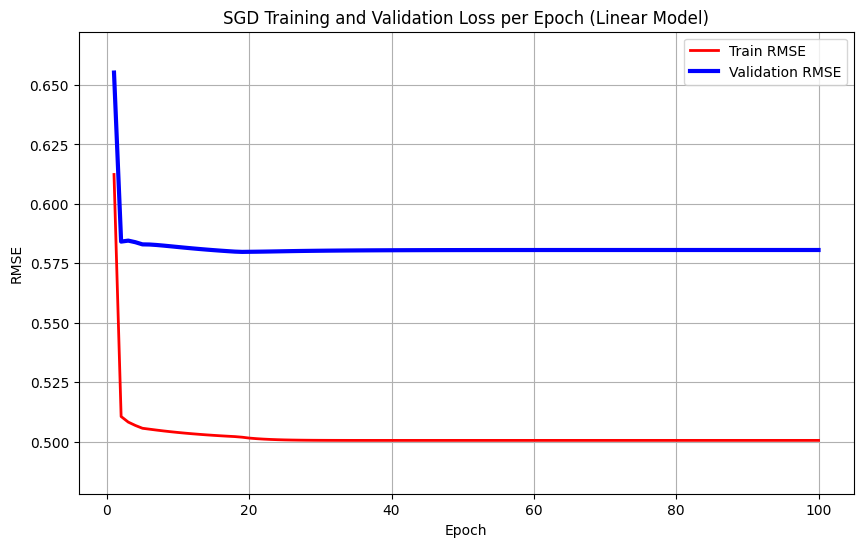

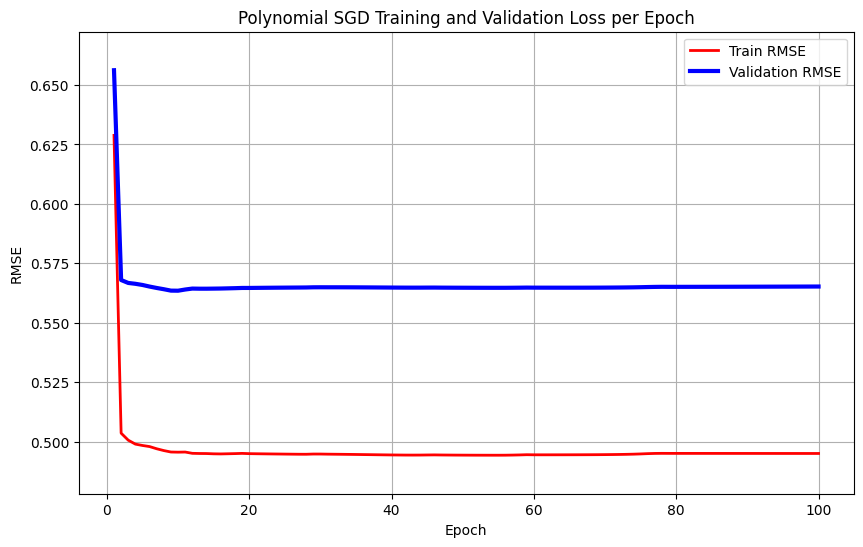

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

if 'best_overall_params' not in locals():
    best_overall_params = {'penalty': 'l1', 'alpha': 0.01, 'degree': 2}
    print("Note: Using placeholder 'best_overall_params'. Ensure this is defined in your full script.")

# ==============================================================================
# SECTION 1: TRAIN LINEAR MODEL AND GATHER LEARNING DATA
# ==============================================================================
print("\n--- Generating data for Linear SGD Model learning curve ---")

# 1.1: Create a train/validation split for epoch monitoring ---
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED
)

# 1.2: Set up the preprocessing pipeline for linear features ---
base_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_train_part_processed = base_pipeline.fit_transform(X_train_part)
X_val_part_processed = base_pipeline.transform(X_val_part)

# 1.3: Initialize the SGD Regressor for the linear model ---
sgd_epoch_model = SGDRegressor(
    penalty=best_overall_params.get('penalty', 'l2'),
    alpha=best_overall_params.get('alpha', 0.01),
    max_iter=1, warm_start=True, eta0=0.01, random_state=SEED
)

# 1.4: Train epoch-by-epoch and record RMSE values ---
train_rmse_list, val_rmse_list = [], []
n_epochs = 100
for epoch in range(n_epochs):
    sgd_epoch_model.fit(X_train_part_processed, y_train_part)
    y_train_pred = sgd_epoch_model.predict(X_train_part_processed)
    y_val_pred = sgd_epoch_model.predict(X_val_part_processed)
    train_rmse_list.append(np.sqrt(mean_squared_error(y_train_part, y_train_pred)))
    val_rmse_list.append(np.sqrt(mean_squared_error(y_val_part, y_val_pred)))

# ==============================================================================
# SECTION 2: TRAIN POLYNOMIAL MODEL AND GATHER LEARNING DATA
# ==============================================================================
print("\n--- Generating data for Polynomial SGD Model learning curve ---")

# 2.1: Set up the preprocessing pipeline with polynomial features ---
best_poly_degree = best_overall_params.get('degree', 2)
poly_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly_features', PolynomialFeatures(degree=best_poly_degree, include_bias=False)),
    ('scaler', StandardScaler())
])
X_train_part_poly = poly_pipeline.fit_transform(X_train_part)
X_val_part_poly = poly_pipeline.transform(X_val_part)

# 2.2: Initialize the SGD Regressor for the polynomial model ---
sgd_poly_epoch_model = SGDRegressor(
    penalty=best_overall_params.get('penalty', 'l2'),
    alpha=best_overall_params.get('alpha', 0.01),
    max_iter=1, warm_start=True, eta0=0.01, random_state=SEED
)

# 2.3: Train epoch-by-epoch and record RMSE values ---
poly_train_rmse_list, poly_val_rmse_list = [], []
for epoch in range(n_epochs):
    sgd_poly_epoch_model.fit(X_train_part_poly, y_train_part)
    y_train_pred = sgd_poly_epoch_model.predict(X_train_part_poly)
    y_val_pred = sgd_poly_epoch_model.predict(X_val_part_poly)
    poly_train_rmse_list.append(np.sqrt(mean_squared_error(y_train_part, y_train_pred)))
    poly_val_rmse_list.append(np.sqrt(mean_squared_error(y_val_part, y_val_pred)))

# ==============================================================================
# SECTION 3: VISUALIZE AND COMPARE LEARNING CURVES
# ==============================================================================
print("\n--- Plotting both curves on a consistent scale for comparison ---")

# 3.1: Calculate a common y-axis scale for direct comparison ---
all_rmse_values = train_rmse_list + val_rmse_list + poly_train_rmse_list + poly_val_rmse_list
y_min = min(all_rmse_values)
y_max = max(all_rmse_values)

# Add a small buffer for better visualization
y_buffer = (y_max - y_min) * 0.1
y_axis_limits = [y_min - y_buffer, y_max + y_buffer]


# 3.2: Plot the learning curve for the Linear Model ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_rmse_list, "r-", linewidth=2, label="Train RMSE")
plt.plot(range(1, n_epochs + 1), val_rmse_list, "b-", linewidth=3, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("SGD Training and Validation Loss per Epoch (Linear Model)")
plt.legend()
plt.grid(True)
plt.ylim(y_axis_limits)
plt.show()


# 3.3: Plot the learning curve for the Polynomial Model ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), poly_train_rmse_list, "r-", linewidth=2, label="Train RMSE")
plt.plot(range(1, n_epochs + 1), poly_val_rmse_list, "b-", linewidth=3, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Polynomial SGD Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
# Apply the common y-axis scale
plt.ylim(y_axis_limits)
plt.show()

# Part F: Final Evaluation On Test Dataset

In [46]:
# ==============================================================================
# PART F: FINAL EVALUATION ON TEST DATA
# ==============================================================================
print("\n--- PART F: FINAL MODEL EVALUATION ON TEST DATA ---")

y_test = test_df['Life Ladder']
X_test = test_df[features]

# --- 1. Evaluate the BEST LINEAR MODEL ---
print("\n--- Evaluating Best Linear Model ---")
best_linear_model.fit(X_train, y_train)
linear_train_pred = best_linear_model.predict(X_train)
linear_test_pred = best_linear_model.predict(X_test)

linear_train_rmse = np.sqrt(mean_squared_error(y_train, linear_train_pred))
linear_test_rmse = np.sqrt(mean_squared_error(y_test, linear_test_pred))

print(f"Final Linear Train RMSE: {linear_train_rmse:.4f}")
print(f"Final Linear Test RMSE:  {linear_test_rmse:.4f}")

# --- 2. Evaluate the BEST POLYNOMIAL MODEL ---
print("\n--- Evaluating Best Polynomial Model ---")
best_poly_model.fit(X_train, y_train)
poly_train_pred = best_poly_model.predict(X_train)
poly_test_pred = best_poly_model.predict(X_test)

poly_train_rmse = np.sqrt(mean_squared_error(y_train, poly_train_pred))
poly_test_rmse = np.sqrt(mean_squared_error(y_test, poly_test_pred))

print(f"Final Polynomial Train RMSE: {poly_train_rmse:.4f}")
print(f"Final Polynomial Test RMSE:  {poly_test_rmse:.4f}")


--- PART F: FINAL MODEL EVALUATION ON TEST DATA ---

--- Evaluating Best Linear Model ---
Final Linear Train RMSE: 0.5184
Final Linear Test RMSE:  0.5322

--- Evaluating Best Polynomial Model ---
Final Polynomial Train RMSE: 0.4213
Final Polynomial Test RMSE:  0.4916


### Final Overfitting/Underfitting Analysis

In [47]:
print("\n--- Final Overfitting/Underfitting Analysis ---")

# --- Linear Model Analysis ---
print("\n--- Linear Model Analysis ---")
print(f"Train RMSE: {linear_train_rmse:.4f} | Test RMSE: {linear_test_rmse:.4f}")
# Check the gap between train and test scores
if linear_test_rmse > linear_train_rmse * 1.15: # If test error is >15% higher
    print("Result: This model shows signs of overfitting.")
else:
    print("Result: This model is well-generalized. The train and test scores are close.")

# --- Polynomial Model Analysis ---
print("\n--- Polynomial Model Analysis ---")
print(f"Train RMSE: {poly_train_rmse:.4f} | Test RMSE: {poly_test_rmse:.4f}")
# Check the gap between train and test scores
if poly_test_rmse > poly_train_rmse * 1.15: # If test error is >15% higher
    print("Result: This model shows slight overfitting due to the gap between train and test scores.")
else:
    print("Result: This model is well-generalized.")

# --- Overall Conclusion based on the FINAL TEST scores ---
print("\n--- Overall Conclusion ---")
if linear_test_rmse < poly_test_rmse:
    print(f"The Linear Model is the better choice. It generalized better to unseen test data, achieving a lower final RMSE.")
else:
    print(f"The Polynomial Model is the better choice. Its ability to capture complex patterns (and control overfitting with regularization and feature selection)")
    print(f"resulted in a lower final test score, making it the more accurate predictor.")


--- Final Overfitting/Underfitting Analysis ---

--- Linear Model Analysis ---
Train RMSE: 0.5184 | Test RMSE: 0.5322
Result: This model is well-generalized. The train and test scores are close.

--- Polynomial Model Analysis ---
Train RMSE: 0.4213 | Test RMSE: 0.4916
Result: This model shows slight overfitting due to the gap between train and test scores.

--- Overall Conclusion ---
The Polynomial Model is the better choice. Its ability to capture complex patterns (and control overfitting with regularization and feature selection)
resulted in a lower final test score, making it the more accurate predictor.


In [48]:
# --- 3. Final Conclusion & Prediction Generation ---
print("\n--- CONCLUSION AND PREDICTION GENERATION ---")
if linear_test_rmse < poly_test_rmse:
    print(f"🏆 The best overall model is the LINEAR model.")
    final_predictions = best_linear_model.predict(X_test)
else:
    print(f"🏆 The best overall model is the POLYNOMIAL model.")
    final_predictions = best_poly_model.predict(X_test)

# --- Save the predictions from the winning model to a CSV file ---
submission_df = pd.DataFrame({'Predicted_Life_Ladder': final_predictions})
submission_df.to_csv('submission_predictions.csv', index=False)
print("\n-> Final predictions have been saved to 'submission_predictions.csv'")


--- CONCLUSION AND PREDICTION GENERATION ---
🏆 The best overall model is the POLYNOMIAL model.

-> Final predictions have been saved to 'submission_predictions.csv'


Citations: Hands on Machine Learning Textbook, LLM: Gemini Pro